## Repères du notebook 
    
   1. [Introduction: Chargement des données et observations](#introduction)
   
   [construction des dataframes pour la simulation](#df)
   
   [Fonctions utiles pour la création des df et la classification](#fonc)
   
   
   
   2. [determiner le clustering initial: Dataframe initial avec optimal K (elbow method)](#p1)
   

   3. [construction des df pour chaque semaine (fonction)](#p2)
   

   4. [Calcul et plot des ARI scores](#p3)
   
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

from sklearn import cluster
from sklearn.metrics.cluster import adjusted_rand_score
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

plt.style.use('seaborn-whitegrid')
#options d'affichage
pd.set_option('display.max_row', 200)
pd.set_option('display.max_column', 70)

### we settled on an actionnable clustering model for olist.

### Time to build a function that generates automatically the dataframes and features needed for this model based on a timespan.

### Then, we predict next timeframe clustering and compare using ARI index to see if clustering holds, and when to recluster.

## 1. Introduction: Chargement des données et observations <a class="anchor" id="introduction"></a>

In [2]:
data = pd.read_pickle("global_orders_data")

In [3]:
data.head()

,order_id,order_purchase_timestamp,customer_unique_id,geolocation_lat,geolocation_lng,time_delivery_customer,company_processing_time,estimation_error_time,purchase_approval_time,order_purchase_dayofweek,order_purchase_hour,month_year,payment_installments,boleto,credit_card,debit_card,voucher,payment_value,number_items,product_width_cm,product_height_cm,product_length_cm,product_weight_g,product_photos_qty,product_description_lenght,product_name_lenght,review_score,freight_value,price,canceled,delivered,None,agro_industry_and_commerce,air_conditioning,art,...,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,pc_gamer,perfumery,pet_shop,portateis_cozinha_e_preparadores_de_alimentos,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,-23.577482,-46.587077,202.477778,56.795833,170.579722,0.178333,0,10,201710,1.0,0.0,1.0,0.0,1.0,38.71,1.0,13.0,8.0,19.0,500.0,4.0,268.0,40.0,4.0,8.72,29.99,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,-12.186877,-44.540232,330.768889,11.109167,128.537500,30.713889,1,20,201807,1.0,1.0,0.0,0.0,0.0,141.46,1.0,19.0,13.0,19.0,400.0,1.0,178.0,29.0,4.0,22.76,118.70,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,-16.745150,-48.514783,225.461111,4.910278,413.891944,0.276111,2,8,201808,3.0,0.0,1.0,0.0,0.0,179.12,1.0,21.0,19.0,24.0,420.0,1.0,232.0,46.0,5.0,19.22,159.90,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,-5.774002,-35.270976,317.010000,89.900000,311.521667,0.298056,5,19,201711,1.0,0.0,1.0,0.0,0.0,72.20,1.0,20.0,10.0,30.0,450.0,3.0,468.0,59.0,5.0,27.20,45.00,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,-23.676257,-46.514580,68.973056,21.434722,221.716111,1.030556,1,21,201802,1.0,0.0,1.0,0.0,0.0,28.62,1.0,15.0,15.0,51.0,250.0,4.0,316.0,38.0,5.0,8.72,19.90,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## construction des dataframes pour la simulation <a class="anchor" id="df"></a>

In [4]:
# au lieu d'une partition par mois, on prend une partition par semaine pour être plus précis dans la simulation:
data['week_year'] = data['order_purchase_timestamp'].map(lambda date: 100*date.year + date.week)
data['week_year']

0        201740
1        201830
2        201832
3        201746
4        201807
          ...  
95546    201710
95547    201806
95548    201734
95549    201802
95550    201810
Name: week_year, Length: 95551, dtype: int64

In [5]:
last_order_date = data['order_purchase_timestamp'].max()
get_recency = lambda date: (last_order_date - date.max()).days

In [6]:
def my_agg(x):
    names = {
        'Recency': get_recency(x['order_purchase_timestamp']),
        'Frequency':  x['order_id'].nunique(),
        'Monetary': x['price'].sum(),
        'review_score': x['review_score'].mean(),
        'freight_value': x['freight_value'].sum(),
        'mean_time_delivery_customer': x['time_delivery_customer'].mean()}
    
    return pd.Series(names)

customer_data = data.groupby(['customer_unique_id', 'week_year']).apply(my_agg)

In [7]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 94565 entries, ('0000366f3b9a7992bf8c76cfdf3221e2', 201819) to ('ffffd2657e2aad2907e67c3e9daecbeb', 201718)
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Recency                      94565 non-null  float64
 1   Frequency                    94565 non-null  float64
 2   Monetary                     94565 non-null  float64
 3   review_score                 94565 non-null  float64
 4   freight_value                94565 non-null  float64
 5   mean_time_delivery_customer  94565 non-null  float64
dtypes: float64(6)
memory usage: 5.5+ MB


In [8]:
customer_data.reset_index(inplace = True)
customer_data.head()

,customer_unique_id,week_year,Recency,Frequency,Monetary,review_score,freight_value,mean_time_delivery_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,201819,111.0,1.0,129.90,5.0,12.00,153.869444
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201819,114.0,1.0,18.90,4.0,8.29,78.854167
2,0000f46a3911fa3c0805444483337064,201710,536.0,1.0,69.00,3.0,17.22,617.562222
3,0000f6ccb0745a6a4b88665a16c9f078,201741,320.0,1.0,25.99,4.0,17.63,480.890000
4,0004aac84e0df4da2b147fca70cf8255,201746,287.0,1.0,180.00,5.0,16.89,315.387222


In [9]:

X = data[data['week_year'] <= 201710]
X.head()

,order_id,order_purchase_timestamp,customer_unique_id,geolocation_lat,geolocation_lng,time_delivery_customer,company_processing_time,estimation_error_time,purchase_approval_time,order_purchase_dayofweek,order_purchase_hour,month_year,payment_installments,boleto,credit_card,debit_card,voucher,payment_value,number_items,product_width_cm,product_height_cm,product_length_cm,product_weight_g,product_photos_qty,product_description_lenght,product_name_lenght,review_score,freight_value,price,canceled,delivered,None,agro_industry_and_commerce,air_conditioning,art,...,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,pc_gamer,perfumery,pet_shop,portateis_cozinha_e_preparadores_de_alimentos,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts,week_year
7,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,39382392765b6dc74812866ee5ee92a7,-27.421769,-52.675022,235.650278,35.428889,753.863889,32.360556,0,18,201701,1.0,1.0,0.0,0.0,0.0,35.95,1.0,15.0,35.0,35.0,300.0,2.0,432.0,41.0,1.0,16.05,19.9,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201704
70,974c1993ab8024d3ed16229183c2308d,2017-02-20 11:45:39,32de2a7a93dbfc527b3f584744b9c6ce,-21.948659,-44.185647,410.705278,27.620833,273.533889,39.411389,0,11,201702,1.0,1.0,0.0,0.0,0.0,84.56,1.0,20.0,8.0,20.0,500.0,2.0,1346.0,47.0,5.0,14.66,69.9,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201708
102,a6cd683d4bd3b9b1f0aa37b27f8116d3,2017-01-28 23:45:53,169381f51e4c3e926ef199364aeced22,-13.001547,-38.461967,305.740556,84.888333,654.494722,1.765278,5,23,201701,6.0,0.0,1.0,0.0,0.0,609.90,1.0,13.0,30.0,35.0,2550.0,1.0,3458.0,55.0,4.0,20.00,589.9,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201704
153,265f4e28ef8cf69f8445e2951bbe7343,2017-03-06 00:14:28,3e45b1d69bfaf0b7963cbb9dd00196f7,-9.899065,-63.061672,345.241111,9.355833,518.517778,0.311944,0,0,201703,1.0,0.0,1.0,0.0,0.0,64.74,1.0,30.0,10.0,30.0,800.0,2.0,1251.0,60.0,4.0,24.84,39.9,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201710
193,a840a7a89e3d9137358eb7b9408681fe,2017-03-09 22:17:49,8a2530b1bf32235ed2636468ea0b1582,-29.172758,-51.210401,154.116111,18.100556,279.586944,0.000000,3,22,201703,5.0,0.0,1.0,0.0,0.0,305.70,1.0,33.0,8.0,31.0,1725.0,3.0,537.0,37.0,5.0,15.80,289.9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201710


## Fonctions utiles pour la création des df et la classification<a class="anchor" id="fonc"></a>

In [10]:
def dataset_creation(data, week):
    X = data[data['week_year'] <= week]
    last_order_date = X['order_purchase_timestamp'].max()
    trunc_customer_data = X.groupby(['customer_unique_id']).apply(my_agg)
    print('dataset created: customer_data up to week {}'.format(week))
    return trunc_customer_data

In [11]:
def displayElbowKMEANS(X, kmin, kmax):
    numeric_transformer = RobustScaler(unit_variance=True)
    X = numeric_transformer.fit_transform(X)
    
    #X = data.values
    model_1 = cluster.KMeans(init='k-means++', random_state=42)
    visualizer_1 = KElbowVisualizer(model_1, k=(kmin, kmax))
    visualizer_1.fit(X)
    visualizer_1.poof()
    k = visualizer_1.elbow_value_
    print('dataset standardised with RobustScaler: X /n', 'value of K for Elbow: {}'.format(k) )
    return X

def displaySilhouette(X, number_clusters):  
    model_2 = cluster.KMeans(number_clusters , init='k-means++', random_state=42)
    visualizer_2 = SilhouetteVisualizer(model_2)
    visualizer_2.fit(X)    # Fit the data to the visualizer
    visualizer_2.poof()


## 2. determiner le clustering initial: Dataframe initial avec optimal K (elbow method)<a class="anchor" id="p1"></a>

In [12]:
Y = list(data['week_year'].unique())
Y.sort()
print(len(Y), '-',Y[-1])
Y.index(201801)
weeks = Y[55:]
weeks

90 - 201835


[201801,
 201802,
 201803,
 201804,
 201805,
 201806,
 201807,
 201808,
 201809,
 201810,
 201811,
 201812,
 201813,
 201814,
 201815,
 201816,
 201817,
 201818,
 201819,
 201820,
 201821,
 201822,
 201823,
 201824,
 201825,
 201826,
 201827,
 201828,
 201829,
 201830,
 201831,
 201832,
 201833,
 201834,
 201835]

In [13]:
#on "entraine" jusqu'à fin 2017 puis on prédit et calcul ARI semaine par semaine:
trunc_data = dataset_creation(data, 201801)

dataset created: customer_data up to week 201801


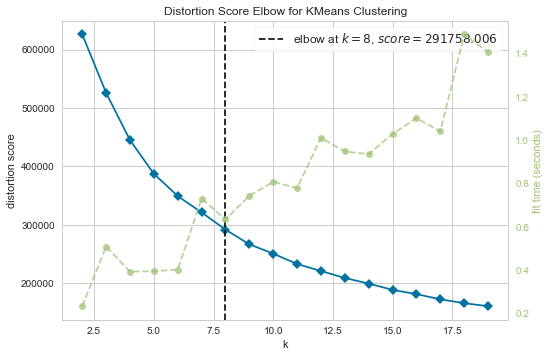

dataset standardised with RobustScaler: X /n value of K for Elbow: 8


In [14]:
X = displayElbowKMEANS(trunc_data, 2, 20)

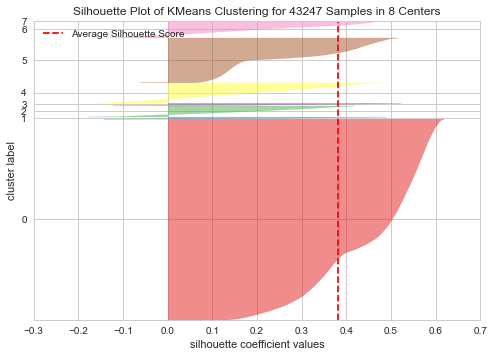

In [15]:
displaySilhouette(X, 8)

## 3. construction des df pour chaque semaine (fonction)<a class="anchor" id="p2"></a>

In [16]:
datasets = []
for i in weeks:
    trunc_data = dataset_creation(data, i)
    datasets.append(trunc_data)
    

dataset created: customer_data up to week 201801
dataset created: customer_data up to week 201802
dataset created: customer_data up to week 201803
dataset created: customer_data up to week 201804
dataset created: customer_data up to week 201805
dataset created: customer_data up to week 201806
dataset created: customer_data up to week 201807
dataset created: customer_data up to week 201808
dataset created: customer_data up to week 201809
dataset created: customer_data up to week 201810
dataset created: customer_data up to week 201811
dataset created: customer_data up to week 201812
dataset created: customer_data up to week 201813
dataset created: customer_data up to week 201814
dataset created: customer_data up to week 201815
dataset created: customer_data up to week 201816
dataset created: customer_data up to week 201817
dataset created: customer_data up to week 201818
dataset created: customer_data up to week 201819
dataset created: customer_data up to week 201820
dataset created: cus

In [17]:
for i in datasets:
    print(i.shape)

(43247, 6)
(44917, 6)
(46546, 6)
(48027, 6)
(49521, 6)
(50986, 6)
(52497, 6)
(54124, 6)
(55880, 6)
(57406, 6)
(58869, 6)
(60482, 6)
(61859, 6)
(63349, 6)
(64800, 6)
(66383, 6)
(67961, 6)
(69620, 6)
(71480, 6)
(73225, 6)
(74113, 6)
(75138, 6)
(76496, 6)
(77940, 6)
(79315, 6)
(80639, 6)
(81774, 6)
(82704, 6)
(84266, 6)
(85811, 6)
(87731, 6)
(89600, 6)
(91363, 6)
(92376, 6)
(92485, 6)


## 4. Calcul et plot des ARI scores<a class="anchor" id="p3"></a>

In [25]:
numeric_transformer = RobustScaler(unit_variance=True)
ari_scores = []
X = numeric_transformer.fit_transform(datasets[0])
model = cluster.KMeans(8 , init='k-means++', random_state=42)

#on compare:
for i,j in zip(datasets[:-1], datasets[1:]):
    
    #initialisation T0: #prediction Ti des données Fi par modele en T0:
    j_scaled = numeric_transformer.transform(j)
    c1_init = model.fit(X).predict(j_scaled)
    
    #nouveaux clusters du nouveau model à Ti sur données Fi:
    c1_new = model.fit(j_scaled).labels_
    
    ari_scores.append(adjusted_rand_score(c1_init, c1_new))
    
    

In [26]:
#autre tentative:
X = numeric_transformer.fit_transform(datasets[0])
Y = numeric_transformer.transform(datasets[1])
model = cluster.KMeans(8 , init='k-means++', random_state=42)
model.fit(X)
d1_predictions = model.predict(Y)
d1_true_labels = model.fit(Y).labels_

print(adjusted_rand_score(d1_predictions, d1_true_labels))



0.5130781348825012


In [27]:
#autre tentative:
X = numeric_transformer.fit_transform(datasets[0])
Y = numeric_transformer.transform(datasets[1])
model = cluster.KMeans(8 , init='k-means++', random_state=42)
model.fit(X)
d1_predictions = model.predict(Y)

Y_bis = numeric_transformer.fit_transform(datasets[1])
d1_true_labels = model.fit(Y).labels_

print(adjusted_rand_score(d1_predictions, d1_true_labels))

0.5130781348825012


In [28]:
datasets[1].head()

,Recency,Frequency,Monetary,review_score,freight_value,mean_time_delivery_customer
customer_unique_id,,,,,,
0000f46a3911fa3c0805444483337064,536.0,1.0,69.00,3.0,17.22,617.562222
0000f6ccb0745a6a4b88665a16c9f078,320.0,1.0,25.99,4.0,17.63,480.890000
0004aac84e0df4da2b147fca70cf8255,287.0,1.0,180.00,5.0,16.89,315.387222
0005e1862207bf6ccc02e4228effd9a0,542.0,1.0,135.00,4.0,15.12,105.015556
0006fdc98a402fceb4eb0ee528f6a8d4,407.0,1.0,13.90,3.0,15.10,393.327500


In [29]:
ari_scores

[0.5130781348825012,
 0.6490867381496921,
 0.9610500906020787,
 0.6556100846854075,
 0.6580994937453779,
 0.6496470965088075,
 0.8167315067223757,
 0.6553529715603803,
 0.6579532157799916,
 0.6611131481476716,
 0.6607006811080249,
 0.6516289939024781,
 0.663953959877957,
 0.6578541587060731,
 0.6563617204381353,
 0.656639208665121,
 0.6554610491178006,
 0.6539737511323122,
 0.6834927956840817,
 0.6550290132833461,
 0.7343992311056311,
 0.6567568406032054,
 0.659720977671609,
 0.6579319927498235,
 0.6667627149141669,
 0.38665147781835024,
 0.3881114809876253,
 0.3845646956674328,
 0.38286929113837403,
 0.38351681828285167,
 0.37993551701836187,
 0.3790604200489373,
 0.37853855826790694,
 0.37801910152288637]

In [30]:
ari_scores

[0.5130781348825012,
 0.6490867381496921,
 0.9610500906020787,
 0.6556100846854075,
 0.6580994937453779,
 0.6496470965088075,
 0.8167315067223757,
 0.6553529715603803,
 0.6579532157799916,
 0.6611131481476716,
 0.6607006811080249,
 0.6516289939024781,
 0.663953959877957,
 0.6578541587060731,
 0.6563617204381353,
 0.656639208665121,
 0.6554610491178006,
 0.6539737511323122,
 0.6834927956840817,
 0.6550290132833461,
 0.7343992311056311,
 0.6567568406032054,
 0.659720977671609,
 0.6579319927498235,
 0.6667627149141669,
 0.38665147781835024,
 0.3881114809876253,
 0.3845646956674328,
 0.38286929113837403,
 0.38351681828285167,
 0.37993551701836187,
 0.3790604200489373,
 0.37853855826790694,
 0.37801910152288637]

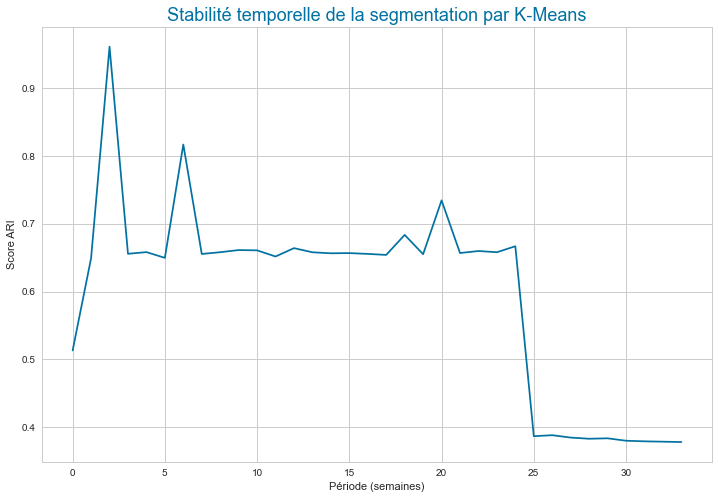

In [31]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_scores)
plt.xlabel("Période (semaines)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()